We want to predict the output value, y, based on inputs, X. In the dataset used as an example, X is fuel prices and unemployment. Y is weekly sales. You can sub in your own data. This is supervised regression.

Our inputs and outputs have different units so we have to scale data for standardization.

This basic Artifical Neural Network has a hidden layer of 3 neurons. We will be using a Sigmuid Activation Function. We'll be performing Batch Gradient Descent and training on a BFGS Algorithm.

Calculus used was learned in my second-year university *Multivariable Calculus* course and matrice work from first-year university *Intro to Linear Algebra* course.

*Model based on the [Neural Networks Demystified](https://www.youtube.com/playlist?list=PLiaHhY2iBX9hdHaRr6b7XevZtgZRa1PoU) series by Stephen Welch.*

*Dataset found [here](https://www.kaggle.com/manjeetsingh/retaildataset).*

#### Data

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from matplotlib.pyplot import *

In [2]:
features = pd.read_csv('./input/Features data set.csv')
sales = pd.read_csv('./input/sales data-set.csv')

In [3]:
features['Date'] = pd.to_datetime(features['Date'])
sales['Date'] = pd.to_datetime(sales['Date'])

df = pd.merge(sales,features, on=['Store','Date', 'IsHoliday'], how='left')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [4]:
df = df.drop(df.columns[[0, 1, 2, 4, 5, 7, 8, 9, 10, 11, 12]], axis=1)
X = df[['Fuel_Price', 'Unemployment']].values
y = df[['Weekly_Sales']].values

#### Scaling

In [5]:
X = X/np.amax(X, axis=0)
y = y/np.amax(y, axis=0)

#### The Artifical Neural Network
**hyperparameters**: constants that define structure and behaviour and are not updated as the network is trained

**forward function**: propogate inputs through network using matrix. inputs are multipled with the weight on each synapses and then added together. from our dataframe above our first row in X is `[ 2.572, 8.106 ]` so the first value in the first row of our hidden layer matrix, z, will be `[ 2.572(W1) + 8.106(W1) . .  ]`. This function gives us the forumla for our hidden layer: `z2 = XW1`

**weights**: representation of the strength of the connection (synpase). they determine the influence an input has on an output or level of activation. we are going to initialize with random values.

In [6]:
class NeuralNetwork(object):
    def __init__(self):
        # hyperparameters
        self.inputLayerSize = 2 # fuel prices and unemployment
        self.outputLayerSize = 1
        self.hiddenLayersSize = 3 # number of neurons
        
        # weights
        self.W1 = np.random.randn(X.shape[1], \
                                 self.hiddenLayersSize)
        self.W2 = np.random.randn(self.hiddenLayersSize, \
                                 self.outputLayerSize)
            
    def forward(self, X):
        # propogate inputs through network
        self.z2 = np.dot(X, self.W1) # input times weights from first layer
        self.a2 = sigmoid(self.z2) # apply activation function
        self.z3 = np.dot(self.a2, self.W2) # second layer of synpases
        yhat = sigmoid(self.z3) # apply activation function
        return yhat # output
    
    # helper methods we will need later on
    def getParams(self):
        # this is formatting
        # returns an array of our weights
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        # this changes our weights
        initialW1 = 0
        finalW1 = self.hiddenLayersSize * self.inputLayerSize
        self.W1 = np.reshape(params[initialW1:finalW1], (self.inputLayerSize , self.hiddenLayersSize))
        finalW2 = finalW1 + self.hiddenLayersSize*self.outputLayerSize
        self.W2 = np.reshape(params[finalW1:finalW2], (self.hiddenLayersSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = costFunctionPrime(model, X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

#### Sigmoid Activation Function
Activation function checks the y value produced by a neuron and decides if it should be considered activated or not. A basic Step function sets a threshold where when the y value is above it, it's activated and below it's not. There is an issue though, it sets up a binary which means learning can jump around. We want something that is analog which will allow for intermediate activation that will smooth out the learning. Besides being analog the activation function we choose also has to be non-linear. This is because no matter how many layers we have applying an activation to each will just create a linear combination of linear functions meaning it will always be a function fo a single layer.

The Sigmoid function introduces non-linearity and looks like a smooth step function solving both our problems. To learn more about the Sigmoid function check out [this](https://www.computing.dcu.ie/~humphrys/Notes/Neural/sigmoid.html).

*This isn't to say Sigmoid funcitons don't have problems either. See [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) for more.*

In [7]:
def sigmoid(z):
    # apply sigmoid activation function
    return 1/(1+np.exp(-z))

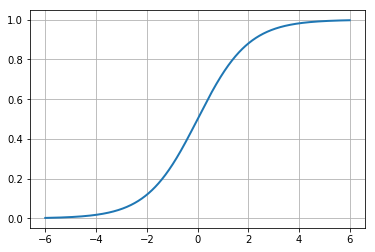

In [8]:
testInput = np.arange(-6,6,0.01)
plot(testInput, sigmoid(testInput), linewidth=2)
grid(1)

This gives the next important formula: `a2 = f(z2)`
    
This means the activity of our second layer is equal to applying the activation function to our hidden layers. a<sup>2</sup> has the same size matrix as z<sup>2</sup>.

#### Forward Propogation
We apply the activation function to our z<sup>2</sup> which is our inputs, X, times the first set of weights, W<sup>1</sup>, which are on the synapses connecting our inputs to first layer of neurons. This get's us a<sup>2</sup> as described above.

To finish forward propogation we need to propgate a<sup>2</sup> all the way to the output y hat. For this we need to multiply a<sup>2</sup> by the weights of the second layer of our hidden layers, W<sup>2</sup>.

We are left with `z3 = a2w2` a matrix of n rows (# of neurons) and 1 column. Finally, like the first layer we have to apply the activation function to z<sup>3</sup>. Leaving us with a formula for y hat: `ŷ = f(z3)` the official estimation of weekly sales.

In [9]:
model = NeuralNetwork()
yHat = model.forward(X)
yHat

array([[0.31688864],
       [0.31692288],
       [0.31696885],
       ...,
       [0.31620342],
       [0.31635086],
       [0.31675405]])

In [10]:
y

array([[0.03596093],
       [0.06642553],
       [0.06001383],
       ...,
       [0.00153083],
       [0.00109654],
       [0.0015536 ]])

At this point, it is evident that are estimates are way off. That's because the model has not been trained.

#### Gradient Descent
First step is to quantify how far off our data is. We have to determine the error with a cost function: `J = ∑ 1/2 (y - ŷ)^2` Now the goal of training is to **minimize** our cost function (minimize error). We do this by changing the weights.

Here is where we break out the university-level calculus. Let's expand J so it is easier to work with, we're just going to sub in 
our input and weights. That gives us the following for our cost function `J = ∑ 1/2 (y - f(f(XW1)W2))^2`

We want to figure out where the cost is going downhill (so we can find the minimum). This means we need the rate of change (slope). Derivatives give the rate of change of a function. We are changing weights (W1, W2) wrt to J so the derivative needed is dJ/dW. We are going to take our weights one at a time so we'll break that into two partial derivatives: `∂J/∂W1` and `∂J/∂W2`

Gradient Descent is a process of iteratively taking steps down towards the minimum.

*Note: cost function is squared because the convex nature of quadratic equations means we won't get stuck in a local minima of a non-convex equation. (Think the shape of a parabola).* 

In [11]:
def costFunction(N, X, y):
    # compute error
    N.yHat = N.forward(X)
    J = 0.5*sum((y-N.yHat)**2)
    return J

#### Backpropagation
Backpropagation can be thought of as performing the chain rule endlessly.

We will start it with our second set of weights.

`∂J/∂W2 = ∂(∑ 1/2(y - ŷ)^2) / ∂W2`

To simply, remove summation, we will add individual computations together later.

`= 1/2(y - ŷ)^2`

Apply power rule.

`= (y - ŷ)`

Apply chain rule. y doesn't change in the model so treat it as a constant. Move the negative from the chain rule ot the front.

`= -(y - ŷ)(∂ŷ/∂W2)`

Remember, ŷ is equal to the activation function applied on z3. This means we must apply the chain rule again.

`= -(y - ŷ)(∂ŷ/∂W2)(∂z3/∂W2)`

Differentiate Sigmoid activation function.

```f(z) = 1/(1+e^(-z))
f′(z) = (0(v) - (1(e^(-z)))) / (1(e^(-z))^2
      = e^(-z) / (1(e^(-z))^2```
      
Sub differentiation result into main partial derivative.

`= -(y - ŷ)(f′(z3))(∂z3/∂W2)`

Before going on to the last term lets apply matrix multiplication to our first two because they are of the same time. This results in the backpropagating error, δ3 which is a matrix of [X.shape, 3]. Delta is also known as sensitivity.

`δ3 = -(y - ŷ)(f′(z3))`

We have are final partial derivative to compute. Remember z3 represents the activity of our second layer multiplied with the weights. Therefore, this term is equal to the activity of each synapse and can be thought of as matrix [X.shape, 3] of a2.

If we transpose the matrix of the final term we are able to finsih the computing ∂J/∂W2. This is also going to take care of the summatation. *(Remember with matrix multiplication the # columns of the first matrix must equal the number of rows in the second matrix.)* Each row in the final matrix looks like `[a2(δ3) + a2(δ3) + a2(δ3) . . . ]` for the number of values in X.

`∂J/∂W2 = δ3(a2T)`

To summarize, we have calculated the gradient (movement down) of each term, we sum them together, and move down in the direction of the sum. Summation is what makes this process Batch Gradient Descent.

In [12]:
def sigmoidPrime(z):
    # derivative of sigmoid function
    return np.exp(-z)/((1+np.exp(-z))**2)

In [13]:
def costFunctionPrime(N, X, y):
    # compute derivative wrt W1 and W2
    N.yHat = N.forward(X)
    
    delta3 = np.multiply(-(y-N.yHat), sigmoidPrime(N.z3))
    dJdW2 = np.dot(N.a2.T, delta3)
    
    # this part is explained in the text below
    delta2 = np.dot(delta3, N.W2.T)*sigmoidPrime(N.z2)
    dJdW1 = np.dot(X.T, delta2)
    
    return dJdW1, dJdW2

The final computation is for our first set of weights: `∂J/∂W1` This is the movement from our inputs across synapses to neurons.

`∂J/∂W1 = ∂(∑ 1/2(y - ŷ)^2) / ∂W1`

Follow the derivation of W2 through until δ3 has been calculated. At this point we have the following:

`= δ3(∂z3/∂W1)`

For W2 the computation was finding the derivative wrt weights **on** synpases. Now, for W1, it's about taking the derivative **across** synapses. Chain rule again.

`= δ3(∂z3/∂W1)(∂a2/∂W1)`

We are still thinking about the relationship of z3 which represents the activity of our second layer multiplied with the weights. This time, we need to transpose the matrix of W2 weights.

`= δ3(W2T)(∂a2/∂W1)`

Chain rule again. This is like our earlier Sigmoid derivative except for z2 this time.

`= δ3(W2T)(∂a2/∂W1)(∂z/∂W1)`

`= δ3(W2T)(f′(z2))(∂z/∂W1)`

The final partial derivative is our inputs. Transpose.

`= δ3(W2T)(f′(z2))(XT)`

Applying the derivative and adding our dJdW1s together across all our examples.

`= δ2(XT)`

In [14]:
# Change our weights to decrease cost
dJdW1, dJdW2 = costFunctionPrime(model, X, y)
dJdW1

array([[-1206.6021178 , -4107.08637481, -3568.39780452],
       [ -923.08788321, -3088.91013053, -2631.09286304]])

#### Numerical Gradient Checking

Our model gives not indication that our calculations are incorrect. The network may learn something that looks *fairly* resonsable while actually being a buggy implementation. This can lead to slowly degrading performance and inaccurate results/conclusions/analysis.

*I loved this [explanation](http://ufldl.stanford.edu/tutorial/supervised/DebuggingGradientChecking/) by Standford.*

So, before training we need to check our derivative procedure. We do this by thinking back to the first week of intro to calculus class where we learned the definition of a derivative (remember taking x to the limit?).

`f'= limΔx→0 f(x+Δx)−f(x)/Δx`

We are going to choose a middle point of our function and call the movements to the left and right as `x - ε` or `x + ε`. Essentially we are going to set Δx to a very very (not extremely) small constant called Epsilon. The calculated approximation will have an error in the range of epsilon squared.

We will calculate `(f(x+epsilon)-f(x-epsilon))/(2*epsilon)` and compare to our test point.

Quick terminology explainer: perturbing means adding a small random value to the weight.

In [15]:
def computeNumericalGradient(N, X, y):
    paramsInitial = N.getParams()
    ngv = np.zeros(paramsInitial.shape)    
    perturb = np.zeros(paramsInitial.shape)
    e = 1e-4 # very very small epsilon value
    
    # add epsilon to current value
    for i in range(len(paramsInitial)):
        perturb[i] = e
        # move right
        
        N.setParams(paramsInitial + perturb) # add to current value
        lossRight = costFunction(N, X, y) # compute cost function based on new weight
        # move left
        N.setParams(paramsInitial - perturb) # subtract from current value
        lossLeft = costFunction(N, X, y) # compute cost function based on new weight
        
        # sub into definition
        ngv[i] = (lossRight - lossLeft) / (2*e)
        
        # reset
        perturb[i] = 0
    
    # reset params
    N.setParams(paramsInitial)
    
    return ngv # numerical gradient vector with same num of values and weights

In [16]:
check = computeNumericalGradient(model, X,  y)
gradient = model.computeGradients(X, y)

In [17]:
check

array([-1206.6021208 , -4107.08637266, -3568.39780048,  -923.08788795,
       -3088.9101285 , -2631.09286176,  3968.23472927, 13315.8750929 ,
        9600.94567796])

In [18]:
gradient

array([-1206.6021178 , -4107.08637481, -3568.39780452,  -923.08788321,
       -3088.91013053, -2631.09286304,  3968.23473019, 13315.87508975,
        9600.94567708])

#### Training
There are many potential issues in using Gradient Descent. For example, hitting a flat spot or bouncing out of the minima because the steps are too large. The Broyden–Fletcher–Goldfarb–Shanno Numerical Optimization Algorithm (BFGS) is a popular specialization that takes the second derivative of the cost function which allows it to reduce the issues seen in traditional Gradient Descent.

I recommend this [resource](https://people.duke.edu/~ccc14/sta-663/MultivariateOptimizationAlgortihms.html) from Duke University to expand your understanding of this algorithm.

We are going to use a built-in scipy package which you can reference [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

For BFGS we used a Jacobian parameter. This is simply a matrix that contains first-order partial derivatives for a vector function.

In order to combat overfitting and mitigate the noise in our data, we should break up our dataset into training and test data.

In [58]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(X, y)

trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/np.amax(trainY, axis=0)
testX = testX/np.amax(testX, axis=0)
testY = testY/np.amax(testY, axis=0)

trainX = np.around(trainX, 1)
trainY = np.around(trainY, 1)
testX = np.around(testX, 1)
testY = np.around(testY, 1)

In [45]:
class Trainer(object):
    def __init__(self, model):
        self.N = model
    
    def callback(self, params):
        self.N.setParams(params)
        self.J.append(costFunction(self.N, self.X, self.y))
        self.testJ.append(costFunction(self.N, self.testX, self.textY))
    
    # optimize.minimize takes a tuple
    def wrapper(self, params, X, y):
        self.N.setParams(params)
        cost = costFunction(self.N, X, y)
        grad = self.N.computeGradients(X, y)
        return cost, grad
    
    def train(self, trainX, trainY, testX, testY):
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.textY = testY
        
        # list to store costs
        self.J = []
        self.testJ = []
        
        # initial params
        int_params = self.N.getParams()
        
        # do max 200 iterations and print the convergence message
        options = {'maxiter': 2000, 'disp': True}
        # after each iteration we add result to our list and replace random params with trained ones (callback)
        res = optimize.minimize(self.wrapper, int_params, jac = True, method = 'BFGS', args = (trainX, trainY), callback = self.callback, options=options)
        
        self.N.setParams(res.x)
        self.optimizationResults = res

In [59]:
TR = Trainer(model)
TR.train(trainX, trainY, testX, testY)

Optimization terminated successfully.
         Current function value: 245.893805
         Iterations: 13
         Function evaluations: 14
         Gradient evaluations: 14


Text(0,0.5,'Cost')

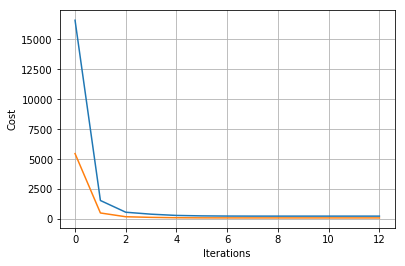

In [60]:
plot(TR.J)
plot(TR.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')